In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import random
import math
import torch
import torch_geometric
from torch.utils.data import Dataset, random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_undirected

import e3nn
from functools import partial
import itertools

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))
print("e3nn version {}".format(e3nn.__version__))

from experiments.utils.plot_utils import plot_2d, plot_3d
from experiments.utils.train_utils import run_experiment_reg
from models import SchNetModel, DimeNetPPModel, SphereNetModel, EGNNModel, GVPGNNModel, TFNModel, MACEModel

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version 1.12.1+cu113
PyG version 2.3.1
e3nn version 0.5.1
Using device: cuda


In [52]:
def create_paired_star_graphs_with_two_centers(num=5, fold=[5,], dim=3, n_pairs=2, seed=0):
    """Generate star graphs where spokes have random angles; certain nodes are paired up to be used for prediction.
    There are two centers (connected to every other nodes).
    
    ----------
    Parameters:
    - num (int): number of star graphs to generate
    - fold (list of int): number of spokes to be considered when generating star graphs
    - dim (int): range of random angles (2D or 3D)
    - n_pairs (int): number of distinct pairs of nodes to be used in angle prediction
    - seed (int): random seed
    """

    assert dim == 2 or dim == 3, "dimension must be 2 or 3."
    assert n_pairs * 2 <= min(fold), "minimum fold must be >= two times the number of pairs."

    torch.manual_seed(seed)
    random.seed(seed)

    dataset = []

    for _ in range(num):
        n_spoke = random.choice(fold)
        # atoms representing central and non-central nodes
        pair_labels = []
        for i in range(n_pairs):
            pair_labels += [i+1,] * 2
        # two centers, one at the front and the other at the back
        atoms = torch.LongTensor( [0,] + pair_labels + [n_pairs+1,] * (n_spoke - 2*n_pairs) + [0,])

        # two centers connect to every other node
        edges1 = [0,] * (n_spoke + 1) + [n_spoke + 1,] * n_spoke
        edges2 = list(range(1, n_spoke + 2)) + list(range(1, n_spoke + 1))
        edge_index = torch.LongTensor( [ edges1, edges2 ] )

        # first spoke and the first center
        x = torch.Tensor([1, 0, 0])
        pos = [torch.Tensor([0, 0, 0]), x]  

        if dim == 2:
            for count in range(n_spoke):
                # random angle between 0 and 2*pi
                random_angle = random.uniform(0, 2 * math.pi)
                new_point = torch.Tensor([math.cos(random_angle), math.sin(random_angle), 0])
                pos.append(new_point)

        elif dim == 3:
            for count in range(n_spoke):
                theta = random.uniform(0, 2 * math.pi)  # Random angle around z-axis
                phi = random.uniform(0, math.pi)  # Random angle from z-axis (polar angle)
                new_point = torch.Tensor([
                    math.sin(phi) * math.cos(theta),
                    math.sin(phi) * math.sin(theta),
                    math.cos(phi)
                ])
                pos.append(new_point)

        # scale pos of spokes to increase variance of target angles
        avg_vec = sum(pos)
        alpha = random.uniform(-1, 2)
        pos1 = [p + alpha * avg_vec for p in pos[1:-1]]
        pos = pos[:1] + [v / torch.norm(v, p=2) for v in pos1] + pos[-1:]
        
        # compute angles between paired nodes and the first center
        target_angles1 = []
        spoke_positions = pos[1:(2*n_pairs + 1)]
        for j in range(n_pairs):
            v1, v2 = spoke_positions[2*j], spoke_positions[2*j+1]
            angle = torch.acos(torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2)))
            target_angles1.append(angle)

        # compute angles between paired nodes and the second center
        target_angles2 = []
        spoke_positions = pos[1:(2*n_pairs + 1)]
        for j in range(n_pairs):
            v1, v2 = spoke_positions[2*j] - pos[-1], spoke_positions[2*j+1] - pos[-1]
            angle = torch.acos(torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2)))
            target_angles2.append(angle)

        y = torch.Tensor(target_angles1 + target_angles2)
        
        print(target_angles2)
        print(pos)
        
        pos = torch.stack(pos)
        data = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
        data.edge_index = to_undirected(data.edge_index)
        dataset.append(data)

    return dataset

[tensor(0.6625)]
[tensor([0., 0., 0.]), tensor([0.9993, 0.0053, 0.0374]), tensor([ 0.2519, -0.9259,  0.2816]), tensor([-0.0560,  0.9978, -0.0354])]
[tensor(0.2787)]
[tensor([0., 0., 0.]), tensor([-0.4418,  0.3891, -0.8083]), tensor([-0.8480,  0.2655, -0.4586]), tensor([ 0.4924, -0.3988,  0.7736])]
[tensor(0.3390)]
[tensor([0., 0., 0.]), tensor([ 0.7236, -0.3048, -0.6193]), tensor([ 0.4867, -0.5232, -0.6996]), tensor([-8.9003e-04,  2.7976e-01, -9.6007e-01])]
[tensor(1.0604)]
[tensor([0., 0., 0.]), tensor([ 0.9518,  0.0502, -0.3025]), tensor([ 0.2126,  0.5445, -0.8114]), tensor([ 0.6740, -0.4972, -0.5464])]
[tensor(0.9997)]
[tensor([0., 0., 0.]), tensor([0.7677, 0.0957, 0.6336]), tensor([-0.2568,  0.4713,  0.8437]), tensor([-0.3807, -0.4626,  0.8007])]


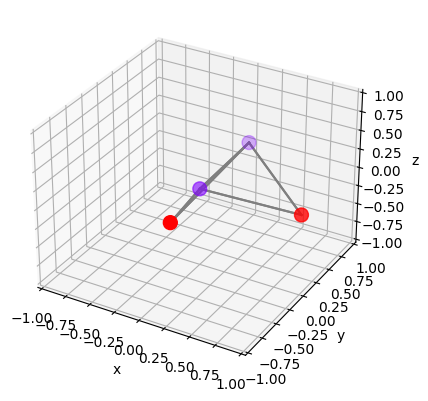

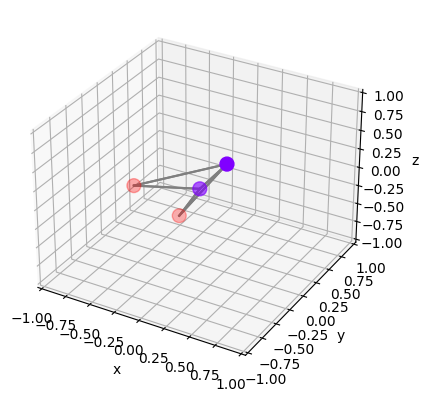

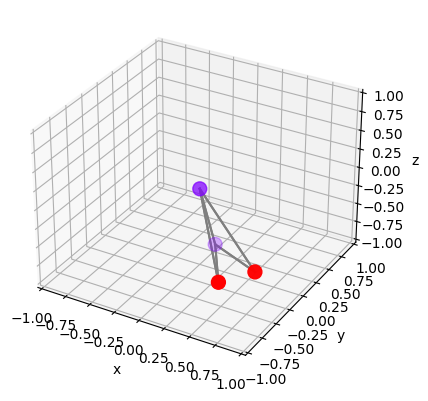

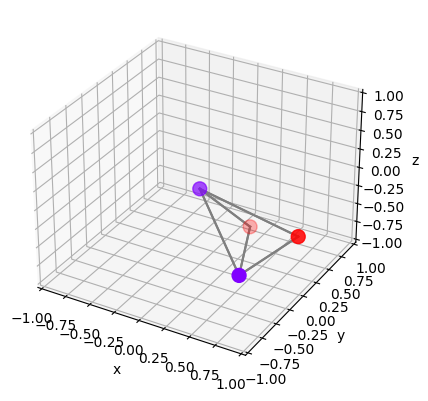

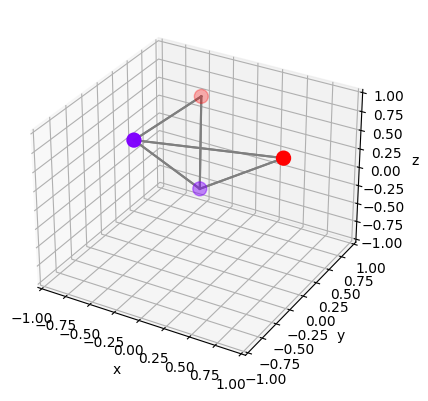

In [54]:
dataset = create_paired_star_graphs_with_two_centers(num=5, fold=[2,], dim=3, n_pairs=1)

for data in dataset:
    plot_3d(data, lim=1)

In [37]:
def create_paired_complete_graphs(num=5, n_nodes=[6,], dim=3, n_pairs=2, seed=0):
    """Generate complete graphs where spokes have random angles; target can be the max angle or the average angle.
    
    ----------
    Parameters:
    - num (int): number of star graphs to generate
    - n_nodes (list of int): number of nodes of the complete graph
    - dim (int): range of random angles (2D or 3D)
    - n_pairs (int): number of distinct pairs of nodes to be used in angle prediction
    - seed (int): random seed
    """

    assert dim == 2 or dim == 3, "dimension must be 2 or 3."
    assert n_pairs * 2 + 1 <= min(n_nodes), "minimum fold must be >= two times the number of pairs."

    torch.manual_seed(seed)
    random.seed(seed)

    dataset = []

    for _ in range(num):
        n_node = random.choice(n_nodes)
        # label paired nodes with distinct numbers
        pair_labels = []
        for i in range(n_pairs):
            pair_labels += [i+1,] * 2

        atoms = torch.LongTensor( [0,] + pair_labels + [n_pairs+1,] * (n_node - 2*n_pairs - 1) )

        # edges read vertically; complete graph: 0 -> 1, 0 -> 2, ..., 1 -> 2, 1 -> 3, ...
        edge_index = torch.LongTensor([
            [i for i in range(n_node) for j in range(i + 1, n_node)],
            [j for i in range(n_node) for j in range(i + 1, n_node)]
        ])

        # origin
        pos = [torch.Tensor([0, 0, 0])]  

        if dim == 2:
            for _ in range(n_node-1):
                # random angle between 0 and 2*pi
                random_angle = random.uniform(0, 2 * math.pi)
                new_point = torch.Tensor([math.cos(random_angle), math.sin(random_angle), 0])
                pos.append(new_point)

        elif dim == 3:
            for _ in range(n_node-1):
                theta = random.uniform(0, 2 * math.pi)  # Random angle around z-axis
                phi = random.uniform(0, math.pi)  # Random angle from z-axis (polar angle)
                new_point = torch.Tensor([
                    math.sin(phi) * math.cos(theta),
                    math.sin(phi) * math.sin(theta),
                    math.cos(phi)
                ])
                pos.append(new_point)

        # scale pos to increase variance of angles
        avg_vec = sum(pos)
        alpha = random.uniform(-1, 2)
        pos1 = [p + alpha * avg_vec for p in pos[1:]]
        pos = pos[:1] + [v / torch.norm(v, p=2) for v in pos1] 

        # compute angles between paired nodes and the origin
        target_angles = []
        spoke_positions = pos[1:(2*n_pairs + 1)]
        for j in range(n_pairs):
            v1, v2 = spoke_positions[2*j], spoke_positions[2*j+1]
            angle = torch.acos(torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2)))
            target_angles.append(angle)

        y = torch.Tensor(target_angles)
        
        pos = torch.stack(pos)
        data = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
        data.edge_index = to_undirected(data.edge_index)
        dataset.append(data)

    return dataset

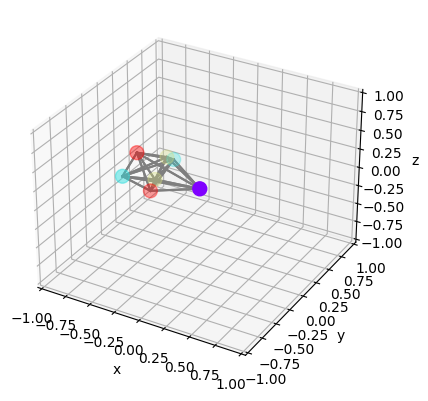

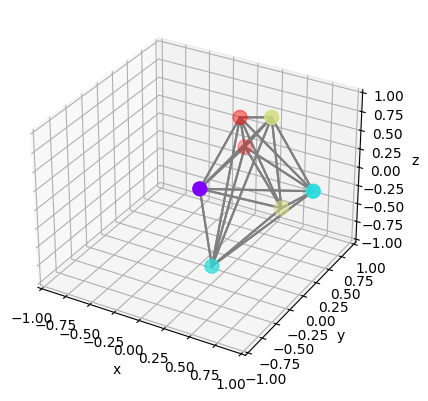

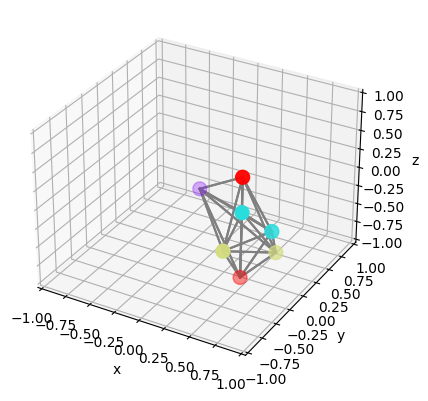

In [38]:
dataset = create_paired_complete_graphs(num=5, n_nodes=[7,], dim=3, n_pairs=2)

for data in dataset[:3]:
    plot_3d(data, lim=1)

In [59]:
my_list = [[1, 2, 3, 4], [5, 6, 7, 8]]

torch.nn.functional.l1_loss(my_list.view(-1, 2)[::2], my_list.view(-1, 2)[::2]+1, reduction='mean')

tensor(1.)

In [60]:
my_list.view(-1)

tensor([1., 2., 3., 4., 5., 6., 7., 8.])